## Generate Solutions to the Sod Shock Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sodshock

import pickle as pkl

In [2]:
# sodshock.solve() defines state as (pressure p, density rho, velocity u)
# in the sod shock tube, initial velocity should be zero everywhere

def generate_sod_shock_solutions(n_sols=500, p_l_range=(1, 5), right_state=(0.1, 0.125, 0), geometry=(0., 1., 0.5), npts=500, t=0.1, gamma=1.4):
    """ Uses the sodshock package wrien by Isaac Backus, (https://github.com/ibackus/sod-shocktube/tree/master). Some of this documentation is directly copied from their repository.
        Generates n_sols total solutions to the sod shock tube problem in the low pressure ratio regime (1 <= p:rho <= 5) with left density set to 1 and standard right state.
    
        Args:
            n_sols (int): # of solutions to be generated. default is 500
            p_l_range: tuple
                A tuple of the range for left pressure (low, high) to initialize the problem with. default is (1, 5) 
            right_state: tuple
                A tuple of the state (pressure, density, velocity) on the right side of the
                shocktube barrier for the ICs.  In the case of a dusty-gas, the density
                should be the gas density.
            geometry: tuple
                A tuple of positions for (left boundary, right boundary, barrier)
            t: float
                Time to calculate the solution at
            gamma: float
                Adiabatic index for the gas.
            npts: int
                number of points for array of pressure, density and velocity


        Returns:
            pkl file containing solutions: each solution is in the form [init_conditions, positions, regions, values], where values contains the solution at the final time, 
                                           init_conditions specifices our input, and positions/reigons provides qualitative information.
            positions: dict
                Locations of the important places (rarefaction wave, shock, etc...)
            regions: dict
                constant pressure, density and velocity states in distinct regions
            values: dict
                Arrays of pressure, density, and velocity as a function of position.
                The density ('rho') is the gas density
                Also calculates the specific internal energy
    """
    dataset = []
    left_pressure = np.linspace(p_l_range[0], p_l_range[1], n_sols)
    for n in range(n_sols):
        left_state = (left_pressure[n], 1, 0)
        positions, regions, values = sodshock.solve(left_state=left_state, right_state=right_state, geometry=geometry,npts=npts, t=t, gamma=gamma)
        
        x = values['x']
        p_final = values['p']
        rho_final = values['rho']
        u_final = values['u']
        
        # need to spatialize left_state, right_state
        barrier_loc = int(npts/2-1)
        p_init = np.zeros_like(p_final)
        rho_init = np.zeros_like(rho_final)
        u_init = np.zeros_like(u_final)
        
        for i in range(barrier_loc+1):
            p_init[i] = left_state[0]
            rho_init[i] = left_state[1]
            u_init[i] = left_state[2]
        for i in range(barrier_loc+1, len(x)):
            p_init[i] = left_state[0]
            rho_init[i] = left_state[1]
            u_init[i] = left_state[2]
            
        init_conditions = [x, p_init, rho_init, u_init]
        final_sol = [p_final, rho_final, u_final]
        states = (left_state, right_state)
        dataset.append((init_conditions, final_sol, positions, regions, states))
    
    with open("sod_shock_dataset.pkl", "wb") as f:
        pkl.dump(dataset, f)


In [3]:
# left_pressure = np.linspace(1, 5, 500)
# left_pressure

In [4]:
generate_sod_shock_solutions()

In [5]:
with open("sod_shock_dataset.pkl", "rb") as f:
    solutions = pkl.load(f)

init_conditions, final_sol, positions, regions, states = solutions[399]
#init_conditions
#final_sol

In [6]:
#nsols = 501
#range = (1, 5)
#np.linspace(range[0], range[1], nsols)

## Split Train and Test Data

In [10]:
# 75 - 25% Train-Test Split
# Train on p in [1, 4), Test on p in (4, 5]

train_data = solutions[:375]
train_input = []
train_output = []
for data in train_data:
    init_conditions, final_output, _, _, _ = data
    train_input.append(init_conditions)
    train_output.append(final_output)
    
    
test_data = solutions[375:]
test_input = []
test_output = []
for data in test_data:
    init_conditions, final_output, _, _, _ = data
    test_input.append(init_conditions)
    test_output.append(final_output)

#for data in train_data:
#    _, _, _, _, states = data
#    print(states[0])

with open("./inputs_train.pkl", "wb") as file:
    pkl.dump(train_input, file)

with open("./outputs_train.pkl", "wb") as file:
    pkl.dump(train_output, file)
    
with open("./inputs_test.pkl", "wb") as file:
    pkl.dump(test_input, file)
    
with open("./outputs_test.pkl", "wb") as file:
    pkl.dump(test_output, file)
#len(train_data)    
#len(test_data)

In [11]:
import torch
train_output = torch.as_tensor(train_output)
train_output.shape

/var/folders/mq/s0kyl1rx0kbc_zptw011wgdw0000gn/T/ipykernel_55512/1651808121.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403212643/work/torch/csrc/utils/tensor_new.cpp:278.)
  train_output = torch.as_tensor(train_output)


torch.Size([375, 3, 500])

# Plot Example Final Sols

Initial Conditions:
Left State: (1.0, 1, 0)
Right State: (0.1, 0.125, 0)
Positions:
Head of Rarefaction : 0.3816784043380077
Foot of Rarefaction : 0.4929727187438817
Contact Discontinuity : 0.5927452620048951
Shock      : 0.6752155732030178
Regions:
Region 1   : (1.0, 1, 0)
Region 2   : RAREFACTION
Region 3   : (0.30313017805064707, 0.42631942817849544, 0.9274526200489506)
Region 4   : (0.30313017805064707, 0.26557371170530725, 0.9274526200489506)
Region 5   : (0.1, 0.125, 0)


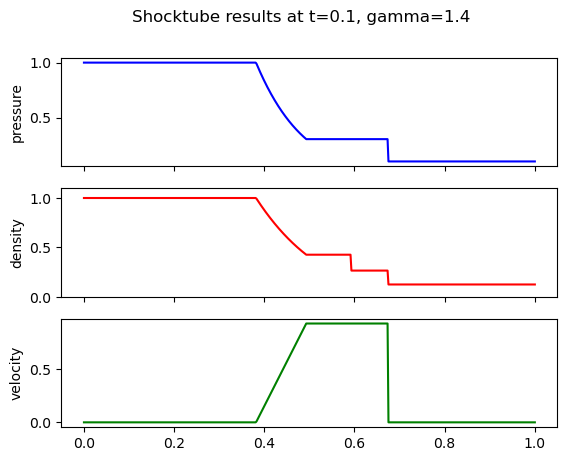

Initial Conditions:
Left State: (2.2024048096192383, 1, 0)
Right State: (0.1, 0.125, 0)
Positions:
Head of Rarefaction : 0.3244048197282473
Foot of Rarefaction : 0.5118335032215936
Contact Discontinuity : 0.6561905695777887
Shock      : 0.7350733805415527
Regions:
Region 1   : (2.2024048096192383, 1, 0)
Region 2   : RAREFACTION
Region 3   : (0.5589530649920171, 0.3755149935953179, 1.561905695777886)
Region 4   : (0.5589530649920171, 0.3725041261675136, 1.561905695777886)
Region 5   : (0.1, 0.125, 0)


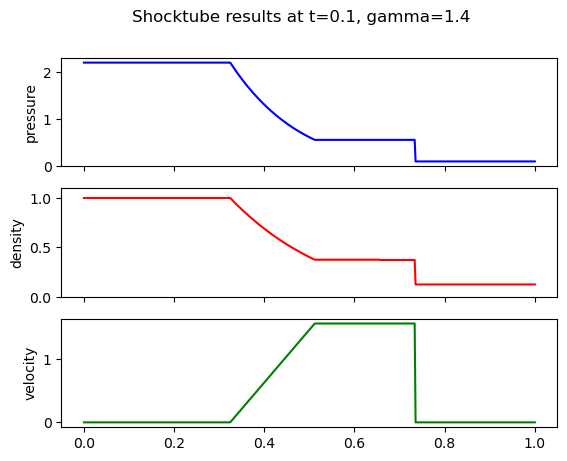

Initial Conditions:
Left State: (3.004008016032064, 1, 0)
Right State: (0.1, 0.125, 0)
Positions:
Head of Rarefaction : 0.2949241305651762
Foot of Rarefaction : 0.5204390332827474
Contact Discontinuity : 0.687929085597976
Shock      : 0.7673997574620279
Regions:
Region 1   : (3.004008016032064, 1, 0)
Region 2   : RAREFACTION
Region 3   : (0.7281523988619935, 0.363389424248114, 1.87929085597976)
Region 4   : (0.7281523988619935, 0.42059503083014804, 1.87929085597976)
Region 5   : (0.1, 0.125, 0)


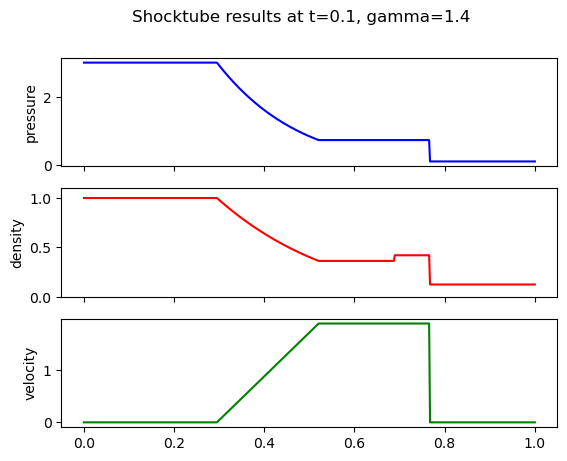

Initial Conditions:
Left State: (3.8056112224448895, 1, 0)
Right State: (0.1, 0.125, 0)
Positions:
Head of Rarefaction : 0.2691785167835792
Foot of Rarefaction : 0.5275205980800459
Contact Discontinuity : 0.7152850677470556
Shock      : 0.7961595364859633
Regions:
Region 1   : (3.8056112224448895, 1, 0)
Region 2   : RAREFACTION
Region 3   : (0.8969840734539651, 0.3561934571466362, 2.152850677470556)
Region 4   : (0.8969840734539651, 0.4577457217092739, 2.152850677470556)
Region 5   : (0.1, 0.125, 0)


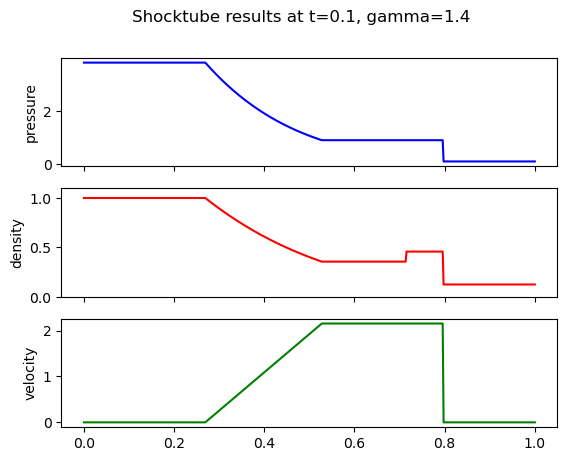

Initial Conditions:
Left State: (5.0, 1, 0)
Right State: (0.1, 0.125, 0)
Positions:
Head of Rarefaction : 0.23542486889354092
Foot of Rarefaction : 0.5363398813497637
Contact Discontinuity : 0.7507625103801856
Shock      : 0.8344071221026279
Regions:
Region 1   : (5.0, 1, 0)
Region 2   : RAREFACTION
Region 3   : (1.1482096178433532, 0.3496294305707839, 2.5076251038018564)
Region 4   : (1.1482096178433532, 0.49974396918161695, 2.5076251038018564)
Region 5   : (0.1, 0.125, 0)


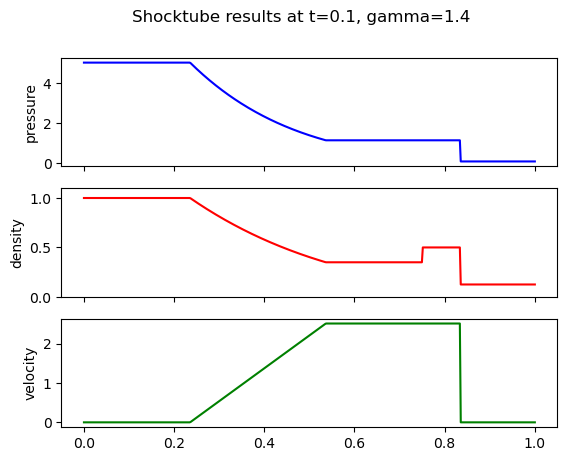

In [8]:
for n in [0, 150, 250, 350, 499]:
    #rng = np.random.default_rng()
    #n = rng.integers(0, 500)
    solution = solutions[n]
    init_conditions, final_sol, positions, regions, states = solution
    # Printing initial conditions
    print("Initial Conditions:")
    print("Left State: " + str(states[0]))
    print("Right State: " + str(states[1]))
    # Printing positions
    print('Positions:')
    for desc, vals in positions.items():
        print('{0:10} : {1}'.format(desc, vals))

    # Printing p, rho and u for regions
    print('Regions:')
    for region, vals in sorted(regions.items()):
        print('{0:10} : {1}'.format(region, vals))

    # Finally, let's plot the solutions
    f, axarr = plt.subplots(3, sharex=True)
    
    x, p_init, rho_init, u_init = init_conditions
    p_final, rho_final, u_final = final_sol
    axarr[0].plot(x, p_final, linewidth=1.5, color='b')
    axarr[0].set_ylabel('pressure')
    # axarr[0].set_ylim(0, 5.1)

    axarr[1].plot(x, rho_final, linewidth=1.5, color='r')
    axarr[1].set_ylabel('density')
    axarr[1].set_ylim(0, 1.1)

    axarr[2].plot(x, u_final, linewidth=1.5, color='g')
    axarr[2].set_ylabel('velocity')
        
    plt.suptitle('Shocktube results at t={0}, gamma={1}'.format(0.1, 1.4))
    plt.show()